## XGBoost ML-Model. 

###### A. part of Notebook is regional learning with the Norway dataset. B. part is transfer learning with Swiss/GLAMOS train set and Norway test set

### Setting Up:

In [1]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), '../../')) # Add root of repo to import MBM

import pandas as pd
import os
import warnings
from tqdm.notebook import tqdm
import re
from calendar import month_abbr
import matplotlib.pyplot as plt
import seaborn as sns
from cmcrameri import cm
import xarray as xr
import massbalancemachine as mbm
from collections import defaultdict
import logging
import numpy as np

from scripts.helpers import *
from scripts.norway_preprocess import *
from scripts.plots import *
from scripts.config_NOR import *
from scripts.xgb_helpers import *

warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

cfg = mbm.NorwayConfig(dataPath='/home/mburlet/scratch/data/DATA_MB/WGMS/Norway/')

In [2]:
seed_all(cfg.seed)
free_up_cuda()

# Plot styles:
path_style_sheet = 'scripts/example.mplstyle'
plt.style.use(path_style_sheet)

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect", # OGGM
    "slope", # OGGM
    "hugonnet_dhdt",  # OGGM
    "consensus_ice_thickness",  # OGGM
]

#### A.1. Read in stake data from preprocess, transform to monthly and add ERA5Land data

###### Load csv into df

In [3]:
data_wgms = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'Nor_dataset_all_oggm.csv')

print('Number of glaciers:', len(data_wgms['GLACIER'].unique()))
print('Number of winter, summer and annual samples:', len(data_wgms[data_wgms.PERIOD == 'annual']) + len(data_wgms[data_wgms.PERIOD == 'winter']) + len(data_wgms[data_wgms.PERIOD == 'summer']))
print('Number of annual samples:',
      len(data_wgms[data_wgms.PERIOD == 'annual']))
print('Number of winter samples:',
      len(data_wgms[data_wgms.PERIOD == 'winter']))
print('Number of summer samples:',
      len(data_wgms[data_wgms.PERIOD == 'summer']))

data_wgms.columns

Number of glaciers: 32
Number of winter, summer and annual samples: 6275
Number of annual samples: 3184
Number of winter samples: 3091
Number of summer samples: 0


Index(['POINT_LAT', 'POINT_LON', 'POINT_ELEVATION', 'FROM_DATE', 'TO_DATE',
       'POINT_BALANCE', 'PERIOD', 'RGIId', 'YEAR', 'GLACIER',
       'DATA_MODIFICATION', 'POINT_ID', 'aspect', 'slope', 'topo',
       'hugonnet_dhdt', 'consensus_ice_thickness'],
      dtype='object')

###### Transform into monthly and add ERA5Land

In [4]:
data_wgms_test = data_wgms.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_NOR_CH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_NOR_CH.nc'
}

RUN = False
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_wgms_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file='NOR_dataset_monthly_full.csv')
data_monthly = dataloader_gl.data

display(data_monthly.head(2))

2025-07-09 07:44:03,990 - INFO - Loaded preprocessed data.
2025-07-09 07:44:03,991 - INFO - Number of monthly rows: 60056
2025-07-09 07:44:03,999 - INFO - Number of annual samples: 38296
2025-07-09 07:44:04,005 - INFO - Number of winter samples: 21760


,YEAR,POINT_LON,POINT_LAT,POINT_BALANCE,ALTITUDE_CLIMATE,ELEVATION_DIFFERENCE,POINT_ELEVATION,RGIId,POINT_ID,ID,...,consensus_ice_thickness,t2m,tp,slhf,sshf,ssrd,fal,str,u10,v10
0,2013,21.77702,70.12589,-4.92,341.344485,129.655515,471,RGI60-08.01258,Langfjordjoekulen_2013_annual_70.12589_21.7770...,0,...,96.980293,-0.428070,0.003846,-55354.0,657502.0,2040907.0,0.439741,-2504336.0,-0.141248,0.397857
1,2013,21.77702,70.12589,-4.92,341.344485,129.655515,471,RGI60-08.01258,Langfjordjoekulen_2013_annual_70.12589_21.7770...,0,...,96.980293,-4.780853,0.003902,178386.0,909366.0,157664.0,0.817481,-1714196.0,-0.183276,1.758524


#### A.2. Dataset statistics

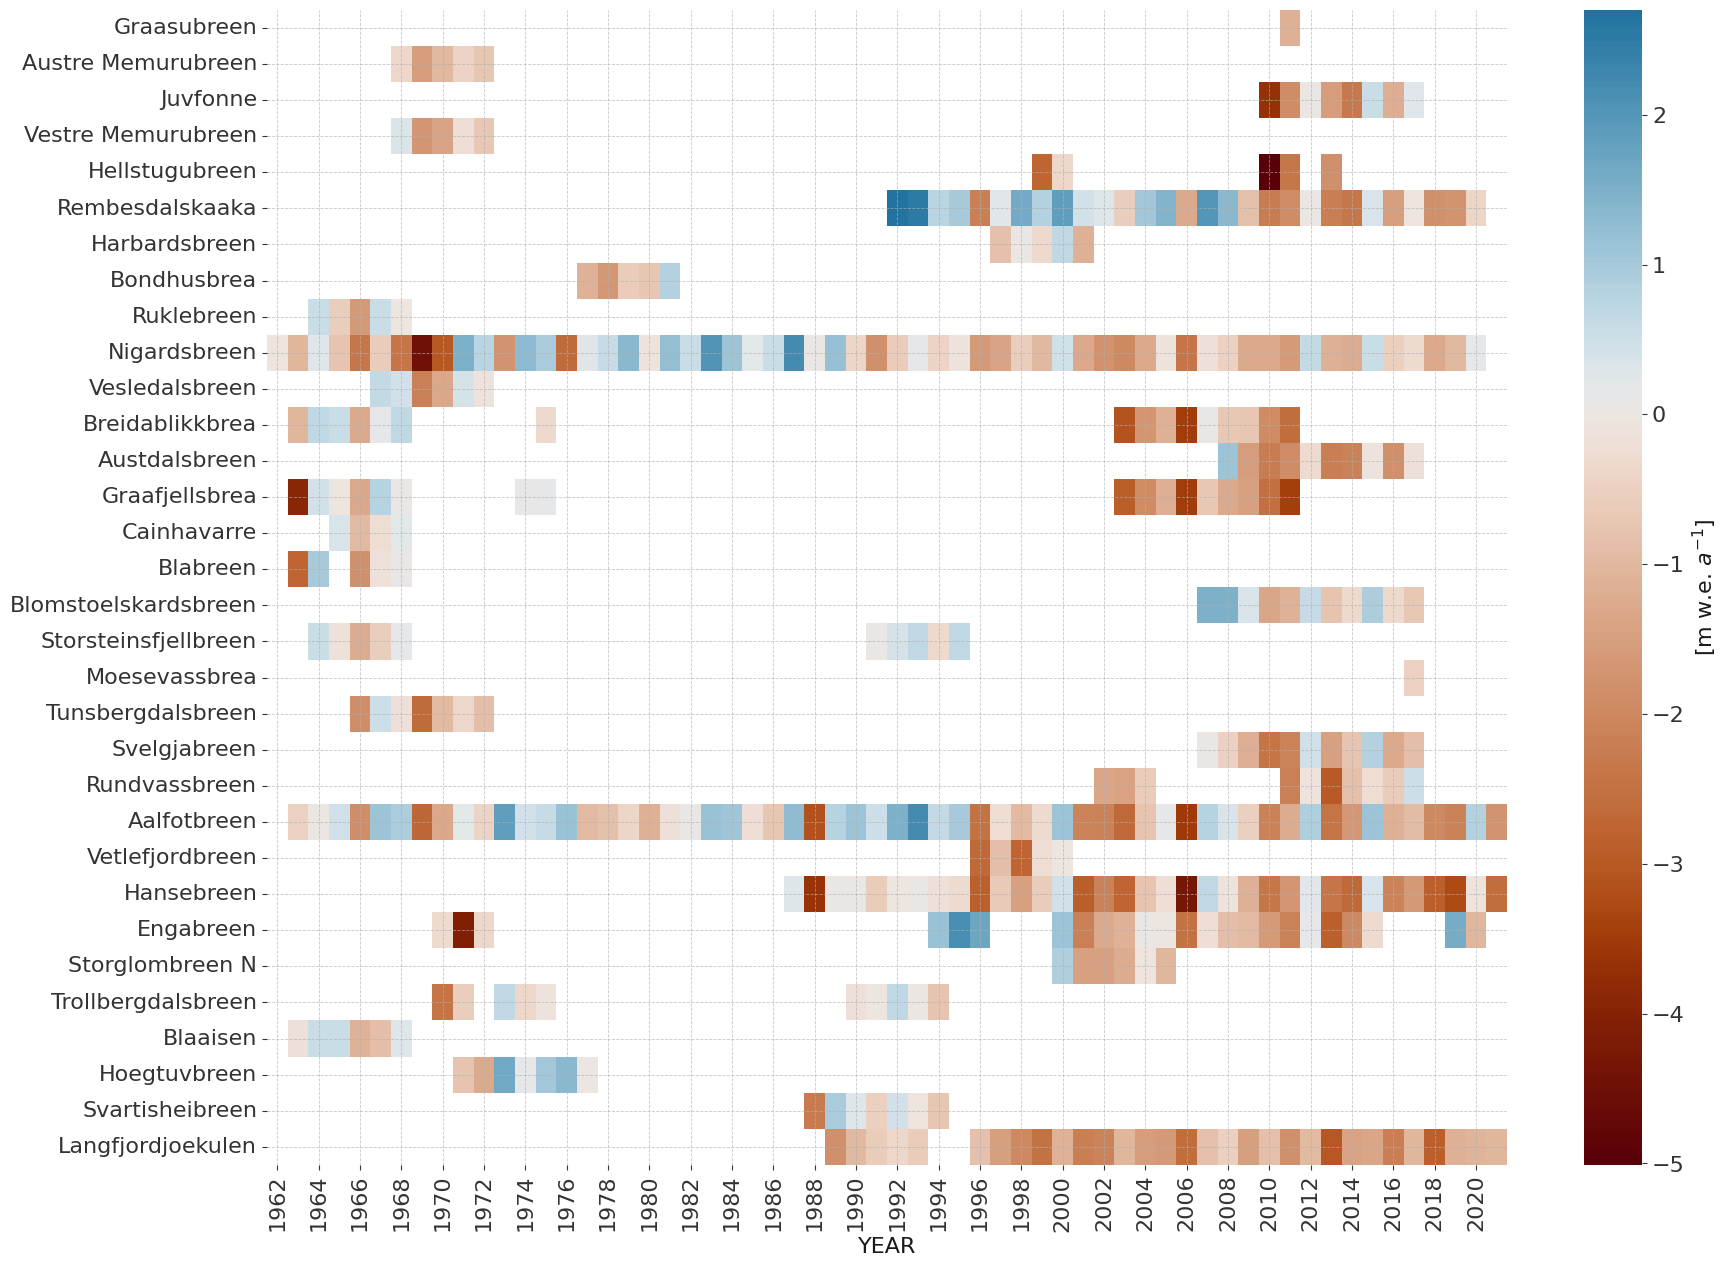

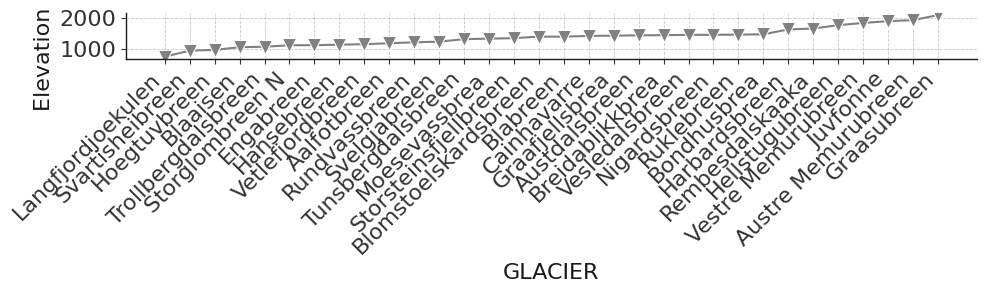

In [5]:
plotHeatmap(data_monthly, period='annual', plot_elevation=True)

Text(0.5, 1.0, 'Number of measurements per year for all glaciers')

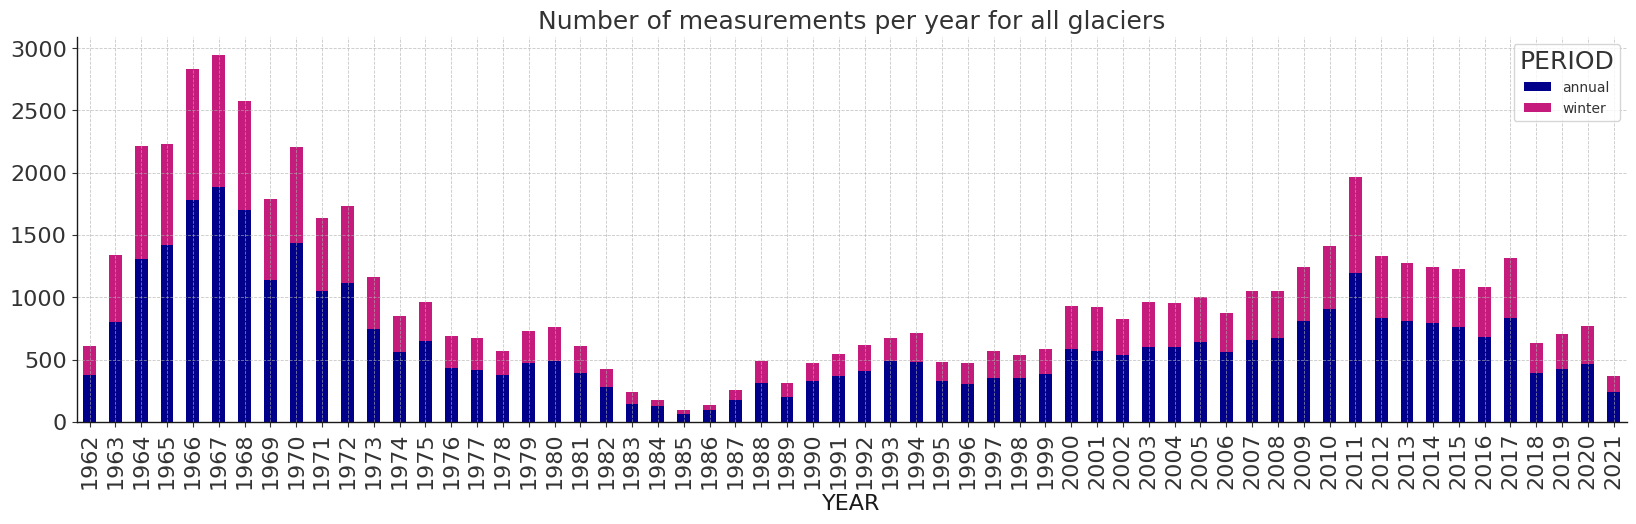

In [6]:
data_monthly.groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar',
    stacked=True,
    figsize=(20, 5),
    color=[color_dark_blue, color_pink])
plt.title('Number of measurements per year for all glaciers')

In [ ]:
# Plot feature intercorrelation
plot_feature_correlation(dataloader_gl.data)


In [ ]:
# Sanity check of variables:
df = dataloader_gl.data
var_to_plot = ['POINT_BALANCE'] + vois_climate
df = df[(df.GLACIER == 'Aalfotbreen') & (df.YEAR == 2015)].groupby(
    ['MONTHS'])[var_to_plot].mean().reset_index()
df['month_nb'] = df.MONTHS.apply(
    lambda x: list(month_abbr).index(x.capitalize()))
df.sort_values(by='month_nb', inplace=True)
fig, ax = plt.subplots(3, 4, figsize=(10, 8))

for i, var in enumerate(var_to_plot):
    df.plot(x='MONTHS', y=var, marker='o', ax=ax.flatten()[i], legend=False)
    if var in vois_climate_long_name.keys():
        ax.flatten()[i].set_title(vois_climate_long_name[var], fontsize=12)
    else:
        ax.flatten()[i].set_title(var, fontsize=12)
plt.tight_layout()

In [ ]:
# Plot the distribution of the topo variables:
df = dataloader_gl.data
fig, axs = plt.subplots(3, 3, figsize=(15, 6))
for i, var in enumerate(vois_topographical + ['ELEVATION_DIFFERENCE']):
    ax = axs.flatten()[i]
    sns.histplot(df[var], ax=ax, kde=True)
    ax.set_xlabel('')
    ax.set_title(var)
plt.tight_layout()

### A.3. Train-test set split:

###### Either run A.3.1. or A.3.2.

##### A.3.1. Spatial Cross-Validation

###### Uses specific glaciers as test set

###### This test set is the same used in the Norway paper

In [ ]:
## find RGIId of Glaciers Kamilla used as test set

glacier_list_df = pd.read_csv(cfg.dataPath + path_PMB_WGMS_raw +'glaciological_point_mass_balance_Norway.csv')
data_NOR = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'Nor_dataset_all_oggm.csv')

# breid ids that Kamilla used as test set
breid_list = [54, 703, 941, 1135, 1280, 2085, 2320, 2478, 2768, 2769, 3133, 3137, 3138, 3141]


breid_to_rgiid = {}
for breid in breid_list:
    matching_row = glacier_list_df[glacier_list_df['breid'] == breid]
    rgiid = matching_row['rgiid'].iloc[0]
    breid_to_rgiid[breid] = rgiid


# Display the mapping
print("Mapping from breid to RGI ID:")
for breid, rgiid in breid_to_rgiid.items():
    print(f"{breid}: {rgiid}")

# Create a list of just the RGI IDs for easy use
test_rgiids = list(breid_to_rgiid.values())
print("\nList of test RGI IDs:")
print(test_rgiids)

rgi_to_glacier = {}

for rgi_id in test_rgiids:
    matching_rows = data_NOR[data_NOR['RGIId'] == rgi_id]
    glacier_name = matching_rows['GLACIER'].iloc[0]
    rgi_to_glacier[rgi_id] = glacier_name


print("RGI ID to Glacier Name mapping:")
for rgi_id, glacier_name in rgi_to_glacier.items():
    print(f"{rgi_id}: {glacier_name}")

norway_kamilla_glacierlist = list(rgi_to_glacier.values())
print("\nList of test RGI IDs:")
print(norway_kamilla_glacierlist)

In [ ]:
"""
test_glaciers = [
    'Vestre Memurubreen', 'Rembesdalskaaka',
    'Blabreen', 'Graafjellsbrea', 'Breidablikkbrea', 'Ruklebreen',
    'Bondhusbrea', 'Svelgjabreen', 'Moesevassbrea',
    'Blomstoelskardsbreen'
]
"""
test_glaciers = norway_kamilla_glacierlist.copy()

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = [i for i in existing_glaciers if i not in test_glaciers]
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

##### A.3.2. Temporal Cross-Validation

###### Uses the last X years as test set

In [ ]:
test_years_count = 10

all_years = sorted(dataloader_gl.data['YEAR'].unique())

# Use the most recent years as test data
train_years = all_years[:-test_years_count]
test_years = all_years[-test_years_count:]

# Statistics prints
print('Size of test data:', len(test_years))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_years)]
print('Size of train data:', len(train_years))
if len(train_years) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(test_years) / len(train_years)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(
                                dataloader_gl,
                                test_split_on='YEAR',
                                test_splits=test_years,
                                random_state=cfg.seed)



print('Train year: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test years: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))

##### A.3.3. Train-Test set plots

In [ ]:
plotHeatmap(dataloader_gl.data, test_glaciers, period='annual')
#plotHeatmap(dataloader_gl.data, test_glaciers, period='winter')
#plotHeatmap(dataloader_gl.data, test_glaciers, period='summer')
visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
test_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
train_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

plot_climate_glacier_elevations(test_glaciers, test_set)

#### A.4. XGBoost:

In [ ]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'gpu_hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = 1

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
]

###### Grid search:

In [ ]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = False
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'xgb_Norway_Kamilla_11_06.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'xgb_Norway_Kamilla_11_06.pkl')

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

In [ ]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

print_top_n_models(custom_xgboost.param_search.cv_results_)

In [ ]:
FIPlot(best_estimator, feature_columns, vois_climate)

###### Predictions of best parameters:

In [ ]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu)
plt.suptitle(f'XGBoost tested on {test_set["splits_vals"]}', fontsize=20)
plt.tight_layout()

In [ ]:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

In [ ]:
PlotPredictionsCombined(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, region_name='Prediction most recent 10 years')

In [ ]:
# Search for points with large prediction errors
grouped_ids_test = grouped_ids.copy()
grouped_ids_test['pmb_diff'] = grouped_ids_test['target'] - grouped_ids_test['pred']
pd.set_option('display.max_colwidth', None) 
display(grouped_ids_test[abs(grouped_ids_test['pmb_diff'] > 5)
])
pd.reset_option('display.max_colwidth')

# Plot climate variables for specific points
point_ids = [
    'Tunsbergdalsbreen_1966_annual_61.55016_7.13566_N_N_2897',
    'Hansebreen_2013_winter_61.75438_5.68309_N_N_5504',
    'Blomstoelskardsbreen_2013_annual_59.9842_6.36128_N_N_3840',
    'Blomstoelskardsbreen_2013_annual_59.93789_6.34729_N_N_3906'
]
plot_point_climate_variables(
    point_ids=point_ids,
    data_monthly=data_monthly,
    vois_climate=vois_climate,
    vois_units=vois_units
)



### B.1. Train CH Test FR

###### Load CH galciers and merge with NOR

In [ ]:
data_CH = pd.read_csv('/home/mburlet/scratch/data/DATA_MB/CH_wgms_dataset_all_04_06_oggm.csv')
data_NOR = pd.read_csv(cfg.dataPath + path_PMB_WGMS_csv + 'Nor_dataset_all_oggm.csv')
display(data_NOR)

display(data_CH.columns)

display(data_NOR.columns)

data_CH = data_CH.drop(['millan_v', 'aspect_sgi', 'slope_sgi', 'topo_sgi'], axis=1)

display(data_CH.columns)

# Merge CH with NOR
data_NOR_CH = pd.concat([data_NOR, data_CH], axis=0).reset_index(drop=True)

display(data_NOR_CH.head(2))

display(len(data_NOR_CH['GLACIER'].unique()))

In [ ]:
data_CH_NOR_test = data_NOR_CH.copy()

# Transform data to monthly format (run or load data):
paths = {
    'csv_path': cfg.dataPath + path_PMB_WGMS_csv,
    'era5_climate_data': cfg.dataPath + path_ERA5_raw + 'era5_monthly_averaged_data_NOR_CH.nc',
    'geopotential_data': cfg.dataPath + path_ERA5_raw + 'era5_geopotential_pressure_NOR_CH.nc'
}

RUN = True
dataloader_gl = process_or_load_data(run_flag=RUN,
                                     df=data_CH_NOR_test,
                                     paths=paths,
                                     cfg=cfg,
                                     vois_climate=vois_climate,
                                     vois_topographical=vois_topographical,
                                     output_file= 'CH_NOR_wgms_dataset_monthly_full.csv')
data_monthly_CH_NOR = dataloader_gl.data

display(data_monthly_CH_NOR.head(2))

In [ ]:
test_glaciers = list(data_NOR['GLACIER'].unique())

# Ensure all test glaciers exist in the dataset
existing_glaciers = set(dataloader_gl.data.GLACIER.unique())
missing_glaciers = [g for g in test_glaciers if g not in existing_glaciers]

if missing_glaciers:
    print(
        f"Warning: The following test glaciers are not in the dataset: {missing_glaciers}"
    )

# Define training glaciers
train_glaciers = list(data_CH['GLACIER'].unique())
data_test = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(test_glaciers)]

# Statistics prints
print('Size of test data:', len(data_test))
data_train = dataloader_gl.data[dataloader_gl.data.GLACIER.isin(
    train_glaciers)]
print('Size of train data:', len(data_train))
if len(data_train) == 0:
    print("Warning: No training data available!")
else:
    test_perc = (len(data_test) / len(data_train)) * 100
    print('Percentage of test size: {:.2f}%'.format(test_perc))

## CV Splits
splits, test_set, train_set = get_CV_splits(dataloader_gl,
                                            test_split_on='GLACIER',
                                            test_splits=test_glaciers,
                                            random_state=cfg.seed)
    
print('Train glaciers: ({}) {}'.format(len(train_set['splits_vals']),
                                      train_set['splits_vals']))
print('Test glaciers: ({}) {}'.format(len(test_set['splits_vals']),
                                      test_set['splits_vals']))


In [ ]:
plotHeatmap(dataloader_gl.data, test_glaciers, period='annual')
#plotHeatmap(dataloader_gl.data, test_glaciers, period='winter')
#plotHeatmap(dataloader_gl.data, test_glaciers, period='summer')
visualiseSplits(test_set['y'], train_set['y'], splits)
visualiseInputs(train_set, test_set, vois_climate)

# Number of measurements per year:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
test_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[0])
ax[0].set_title('Number of measurements per year for test glaciers')

# Number of measurements per year:
train_set['df_X'].groupby(['YEAR', 'PERIOD']).size().unstack().plot(
    kind='bar', stacked=True, color=[color_dark_blue, color_pink], ax=ax[1])
ax[1].set_title('Number of measurements per year for train glaciers')
plt.tight_layout()

plot_climate_glacier_elevations(test_glaciers, test_set)

#### B.2.2. XGBoost Transfer Region

In [ ]:
# Grid search
# For each of the XGBoost parameter, define the grid range
param_grid = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'n_estimators':
    [50, 100, 200, 300, 400, 500, 600,
     700],  # number of trees (too many = overfitting, too few = underfitting)
    'learning_rate': [0.01, 0.1, 0.15, 0.2, 0.25, 0.3]
}

param_init = {}
param_init['device'] = 'cuda:0'
param_init['tree_method'] = 'hist'
param_init["random_state"] = cfg.seed
param_init["n_jobs"] = cfg.numJobs

vois_climate = [
    't2m', 'tp', 'slhf', 'sshf', 'ssrd', 'fal', 'str', 'u10', 'v10'
]

vois_topographical = [
    "aspect",
    "slope",
    "hugonnet_dhdt",
    "consensus_ice_thickness",
    #"millan_v",
]

#### Grid Search

In [ ]:
%%time
# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

RUN = False
if RUN:
    # Create a CustomXGBoostRegressor instance
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg, **param_init)
    custom_xgboost.randomsearch(
        parameters=param_grid,
        n_iter=45,
        splits=splits,
        features=df_X_train_subset,
        targets=train_set['y'],
    )

    # save best model
    custom_xgboost.save_model(f'xgb_CH_11_06_NOR.pkl')
else:
    # read model
    custom_xgboost = mbm.models.CustomXGBoostRegressor(cfg)
    custom_xgboost.load_model(
        f'xgb_CH_11_06_NOR.pkl')

# Get best parameters and estimator
best_params = custom_xgboost.param_search.best_params_
best_estimator = custom_xgboost.param_search.best_estimator_
print("Best parameters:\n", best_params)
print("Best score:\n", custom_xgboost.param_search.best_score_)

# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

# Make predictions on test
features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)

# Calculate scores
score = best_estimator_cpu.score(test_set['df_X'][all_columns],
                                 test_set['y'])  # negative
print('Overall score:', np.abs(score))

In [ ]:
plotGridSearchScore(cv_results_=custom_xgboost.param_search.cv_results_,
                    lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss)
plotGridSearchParams(custom_xgboost.param_search.cv_results_,
                     param_grid,
                     lossType=cfg.loss,
                     N=10)

In [ ]:
FIPlot(best_estimator, feature_columns, vois_climate)

In [ ]:
# Make predictions on test:
# Set to CPU for predictions:
best_estimator_cpu = best_estimator.set_params(device='cpu')

features_test, metadata_test = best_estimator_cpu._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = best_estimator_cpu.predict(features_test)

y_pred_agg = best_estimator_cpu.aggrPredict(metadata_test, features_test)
grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)


PlotPredictions(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu)
plt.suptitle(f'XGBoost tested on NOR trained on CH', fontsize=20)
plt.tight_layout()

In [ ]:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

In [ ]:
PlotPredictionsCombined(grouped_ids, y_pred, metadata_test, test_set,
                best_estimator_cpu, region_name='CH Train NOR Test', include_summer = False)

In [ ]:
# Search for points with large prediction errors
grouped_ids_test = grouped_ids.copy()
grouped_ids_test['pmb_diff'] = grouped_ids_test['target'] - grouped_ids_test['pred']
pd.set_option('display.max_colwidth', None) 
display(grouped_ids_test[abs(grouped_ids_test['pmb_diff'] > 1)
])
pd.reset_option('display.max_colwidth')

# Plot climate variables for specific points
point_ids = [
    'Tunsbergdalsbreen_1966_annual_61.55016_7.13566_N_N_2897',
    'Hansebreen_2013_winter_61.75438_5.68309_N_N_5504',
    'Blomstoelskardsbreen_2013_annual_59.9842_6.36128_N_N_3840',
    'Blomstoelskardsbreen_2013_annual_59.93789_6.34729_N_N_3906'
]
plot_point_climate_variables(
    point_ids=point_ids,
    data_monthly=data_monthly_CH_NOR,
    vois_climate=vois_climate,
    vois_units=vois_units
)

### Predictions of custom parameters:

In [ ]:
custom_params = {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800}

# Feature columns:
feature_columns = [
    'ELEVATION_DIFFERENCE'
] + list(vois_climate) + list(vois_topographical)
all_columns = feature_columns + cfg.fieldsNotFeatures
df_X_train_subset = train_set['df_X'][all_columns]
print('Shape of training dataset:', df_X_train_subset.shape)
print('Shape of testing dataset:', test_set['df_X'][all_columns].shape)
print('Running with features:', feature_columns)

params = {**param_init, **custom_params}
print(params)
custom_model = mbm.models.CustomXGBoostRegressor(cfg, **params)

# Fit on train data:
custom_model.fit(train_set['df_X'][all_columns], train_set['y'])

# Make predictions on test
custom_model = custom_model.set_params(device='cpu')
features_test, metadata_test = custom_model._create_features_metadata(
    test_set['df_X'][all_columns])
y_pred = custom_model.predict(features_test)
print('Shape of the test:', features_test.shape)

# Make predictions aggr to meas ID:
y_pred_agg = custom_model.aggrPredict(metadata_test, features_test)

# Calculate scores
score = custom_model.score(test_set['df_X'][all_columns],
                           test_set['y'])  # negative
print('Overall score:', np.abs(score))

grouped_ids = getDfAggregatePred(test_set, y_pred_agg, all_columns)
PlotPredictions(grouped_ids, y_pred, metadata_test, test_set, custom_model)
plt.suptitle(f'MBM tested on {test_set["splits_vals"]}', fontsize=20)
plt.tight_layout()

# Aggregate predictions to annual or winter:
PlotIndividualGlacierPredVsTruth(grouped_ids, base_figsize=(20, 15))

FIPlot(custom_model, feature_columns, vois_climate)